# **Mounting the Drive**

In [18]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

######
# Define the rtf/txt file path
output_file_path = "/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/My_Draft_Code/ML_HW6_Draft_output.txt"

# Open output file in write mode and clear its contents (if it exists)
output_file = open(output_file_path, 'w')
output_file.close()  # This will clear the contents if the file already exists

# Reopen the output file in append mode to keep it open
output_file = open(output_file_path, 'a')

# Define a custom "pseudo personal print" function
def perprint(message, end = None, file = output_file):
    print(message, end = end)
    print(message, end = end, file = file)
######

perprint("Starting...\n")


Starting...



## **Getting started now!**

In [4]:
import os
import time
import numpy as np
import random
from PIL import Image
from scipy.spatial.distance import pdist, cdist
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# **Paths and directories for input and output files!**

In [5]:

# Variables for input image paths
path_image_1 = '/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/Input_Data/image1.png'
path_image_2 = '/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/Input_Data/image2.png'

# Variables for output directories
dir_kernel_K_means = '/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/My_Draft_Code/Kernel_K_Means'
dir_spectral_clustering_normalized_cut = '/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/My_Draft_Code/Spectral_Clustering_Normalized_Cut'
dir_spectral_clustering_ratio_cut = '/content/drive/MyDrive/NYCU/00- Sem 01 - Fall 2023/Machine Learning/HMW_06/My_Draft_Code/Spectral_Clustering_Ratio_Cut'


# **Kernel K-Means!**

In [6]:

# Function for reading images
def read_image(image_path):
  ''' Read image from path '''
  img_ = Image.open(image_path) # RGB
  ''' Flatten the image <==> color information C(x),
      instead of np.array(img_) <==> (100, 100, 3) '''
  img = np.array(img_.getdata()) # Shape (10000, 3)
  return img

# Function to compute the custom kernel matrix, the Gram matrix
def compute_kernel(x, gamma_s, gamma_c):
    '''
    k(𝑥, 𝑥′) = 𝑒xp( −𝛾_𝑠* ∥𝑆(𝑥)− 𝑆(𝑥′)∥^2 ) * 𝑒xp(−𝛾_𝑐* ∥𝐶(𝑥)− 𝐶(𝑥′)∥^2 )
             = 𝑒xp( −( 𝛾_𝑠 * ∥𝑆(𝑥)− 𝑆(𝑥′)∥^2 + 𝛾_𝑐 * ∥𝐶(𝑥)− 𝐶(𝑥′)∥^2 ) )
    𝛾_𝑠 = gamma_s
    𝛾_c = gamma_c
    𝑆(𝑥) : Spatial information (i.e. the coordinate of the pixel) of data 𝑥.
    𝐶(𝑥) : Color information (i.e. the RGB values) of data 𝑥, == x
    '''

    grid = np.indices((100, 100)).reshape(2, 10000, 1)
    ''' Spatial information '''
    S_x = np.hstack((grid[0], grid[1]))
    ''' ∥𝑆(𝑥)− 𝑆(𝑥′)∥^2 '''
    dist_s = cdist(S_x, S_x, 'sqeuclidean')
    ''' Color information, reshape to (10000, 3) '''
    img_flat = x.reshape(-1, x.shape[-1])
    ''' ∥𝐶(𝑥)− 𝐶(𝑥′)∥^2 '''
    dist_c = cdist(x, x, 'sqeuclidean')
    ''' k(𝑥, 𝑥′) '''
    kernel = np.exp( - (gamma_s * dist_s + gamma_c * dist_c ) )
    return kernel

# Function to compute the squared distance in the feature space
def sq_kernel_distance(kernel, i, j):
    distance_squared = kernel[i, i] - 2 * kernel[i, j] + kernel[j, j]
    return distance_squared

# Function for initializing the centroids
def initial_centroids(kernel, K, number_data_points, mode):
    ''' K is the number of centroids'''
    if mode == 0:
        ''' Random strategy: Randomly select K centroids in the data points '''
        centroids = np.random.choice(number_data_points, K, replace=False) # False avoids choosing same indice twice
        return centroids
    else:
        ''' K-means++ for initializing centroids '''
        ''' First randomly select the first cluster center '''
        centroids = list(random.sample(range(0,number_data_points), 1))
        ''' Then iterate to select the remaining centroids '''
        for number_center in range(1, K):
            ''' np.inf for positive infinite '''
            min_dist = np.full(number_data_points, np.inf)
            for i in range(number_data_points):
                for j in range(number_center):
                    ''' ∥ϕ(xi​) − μ_j​∥^2 , μ_j is center of cluster j '''
                    dist = sq_kernel_distance(kernel, i, centroids[j])
                    if dist < min_dist[i]:
                        min_dist[i] = dist
            min_dist /= np.sum(min_dist)
            ''' Will choose a single point which is biased by the probabilities p'''
            centroids.append(np.random.choice(np.arange(number_data_points), 1, p=min_dist)[0])
        return np.array(centroids)

# Function for the initial cluster assignment
def initial_assignment(kernel, K, initial_centroids, number_data_points):
    ''' Assign each data point to the nearest centroid in the feature space '''
    ''' Initialize an array to store the cluster assignments '''
    initial_clusters = np.zeros(number_data_points, dtype = int)

    ''' Iterate over each data point '''
    for i in range(number_data_points):
        ''' Initialize distances for K clusters '''
        dist = np.zeros(K)
        ''' Iterate over each centroid '''
        for j in range(K):
            ''' Distance from the data point to this centroid '''
            dist[j] = sq_kernel_distance(kernel, i, initial_centroids[j])
        ''' Update the cluster assignment for the data point '''
        initial_clusters[i] = np.argmin(dist)
    return initial_clusters

# Function for subsequent cluster assignments
def subsequent_assignment(kernel, clusters, K, number_data_points):
    ''' Initialize an array to store the cluster assignments '''
    new_clusters = np.zeros(number_data_points, dtype=int)

    ''' Pre-compute the sum of kernel values within each cluster '''
    cluster_kernel_sums = np.array([np.sum(kernel[np.ix_(clusters == k, clusters == k)]) for k in range(K)])
    ''' Sums the True's, number of elements (clusters == k) in each cluster k '''
    cluster_sizes = np.array([np.sum(clusters == k) for k in range(K)])

    ''' Diagonal elements (self-similarity or kernel[i, i]) for each data point '''
    diag_kernel = np.diag(kernel)

    ''' Iterate over each cluster for all data points at once '''
    dist = np.full((number_data_points, K), np.inf)
    ''' Iterate over each centroid '''
    for k in range(K):
        ''' Make sure there is no division by 0 '''
        if cluster_sizes[k] > 0:
            ''' Square kernel distance to centroid k '''

            sum_kernel_to_cluster = np.sum(kernel[:, clusters == k], axis=1)
            dist[:, k] = diag_kernel - (2 / cluster_sizes[k]) * sum_kernel_to_cluster \
                        + (1 / cluster_sizes[k]**2) * cluster_kernel_sums[k]

    ''' Assign new clusters '''
    new_clusters = np.argmin(dist, axis=1)
    return new_clusters

# Function for generating color images based on clusters
def write_image(number_data_points, number_clusters, clusters, model, image_number, output_dir):
    ''' Colors to assign to each cluster '''
    colors = np.array([[150, 255, 200],
                       [0, 255, 0],
                       [0, 0, 255],
                       [0, 200, 255],
                       [255, 200, 0],
                       [255, 0, 150]])
    if number_clusters > 3:
        colors = np.append(colors, np.random.choice(256, (number_clusters - 3, 3)), axis = 0)
    ''' Assigning colors to datapoints '''
    data = colors[clusters]
    ''' Reshape data points to look like an image '''
    image = data.reshape(100, 100, 3)
    ''' Create an image with the data points '''
    image = Image.fromarray(np.uint8(image))
    ''' Save the created image '''
    image.save(os.path.join(output_dir, f"{model}{image_number:02d}.png"))

# Function for saving GIF images
def compose_gif(model, number_images, output_dir):
    ''' Temporary list to save the images read in directory'''
    gif_images = []
    ''' Iterate to read images '''
    for i in range(number_images + 1):
        ''' Path of image '''
        gif_image_path = os.path.join(output_dir, f"{model}{i:02d}.png")
        ''' Read image into the list '''
        gif_images.append(imageio.imread(gif_image_path))
    ''' Transform and save list as GIF inside the directory '''
    imageio.mimsave(os.path.join(output_dir, f"{model}.gif"), gif_images, fps=1)

# Function for computing  Kernel K-Means
def kernel_k_means(image_number, kernel, K, max_iter, mode, directory):
    perprint(f"\t\tImage {image_number} \n\t\t\tStarting Kernel K-Means with K = {k} ...")

    ''' Initializing the centroids '''
    Total = kernel.shape[0]
    centroids = initial_centroids(kernel, K, Total, mode)

    ''' Initial cluster assignment '''
    clusters = initial_assignment(kernel, K, centroids, Total)

    ''' Loop for cluster assignment update and save images for GIF'''
    for iter in range(max_iter):
        ''' Update cluster assignment '''
        new_clusters = subsequent_assignment(kernel, clusters, K, Total)

        ''' Create image based on the new_clusters '''
        write_image(Total, K, new_clusters, f'{mode}_{image_number}_Kernel_{K}_Means', iter, directory)

        ''' Check for convergence '''
        if np.array_equal(new_clusters, clusters):
            last_iteration = iter
            break
        last_iteration = iter
        clusters = new_clusters

    ''' Create GIF from the saved images and save it '''
    compose_gif(f'{mode}_{image_number}_Kernel_{K}_Means', last_iteration, directory)
    print(f"\t\t\tFinished!")

#_______________________________________________________
#_______________________________________________________

if __name__=='__main__':
    # Ensure output directories exist
    os.makedirs(dir_kernel_K_means, exist_ok=True)

    ''' Parameters '''
    k_values = [2, 3, 4] # Number of clusters
    s = 0.0001  # gamma_s of kernel function
    c = 0.001   # gamma_c of kernel function
    max_iter = 30 # Max number of images for the GIF images
    modes = [0, 1] # Integers, if 0 then random initialization, otherwise K-means++ initialization

    #_________________________________________________________
    perprint("2023 ML HMW06 \n\
    Kernel k-means\n\
    Part 1: Clustering into 2 clusters & Visualization.\n\
    Part 2: Try more clusters (e.g. 3 or 4 ...) & Visualization.\n\
    Part 3: Try different initializations (e.g. k-means++) & Visualization.")

    ''' Iterate over different initialization methods '''
    for mode in modes:
        perprint(f"\nMode {mode}")
        ''' Iterate over different number of clusters '''
        for k in k_values:
            perprint(f"\tClusters = {k}")
            ''' Process each image and run clustering algorithms '''
            for index, image_path in enumerate([path_image_1, path_image_2]):
                start_time_image = time.time() # Image processing execution starts

                ''' Read image '''
                start_time_read_image = time.time() # Image reading execution starts
                image = read_image(image_path)

                end_time_read_image = time.time() # Image reading execution ends
                elapsed_time_read_image = int(round(end_time_read_image - start_time_read_image))
                perprint(f"\t\t\tRead Image Execution Time: {elapsed_time_read_image} seconds")

                ''' Compute kernel matrix '''
                start_time_compute_kernel = time.time() # Compute kernel matrix execution starts
                kernel = compute_kernel(image, s, c)

                end_time_compute_kernel = time.time() # Compute kernel matrix execution ends
                elapsed_time_compute_kernel = int(round(end_time_compute_kernel - start_time_compute_kernel))
                perprint(f"\t\t\tCompute Kernel Matrix Execution Time: {elapsed_time_compute_kernel} seconds")

                ''' Kernel k-means '''
                start_time_kmeans = time.time() # Kernel K-Means execution starts
                kernel_k_means(index+1, kernel, k, max_iter, mode, dir_kernel_K_means)

                end_time_kmeans = time.time() # Kernel K-Means execution stops
                elapsed_time_kmeans = int(round(end_time_kmeans - start_time_kmeans))
                perprint(f"\t\t\tKernel K-Means Execution Time: {elapsed_time_kmeans} seconds")

                ''' Get Total Execution Time for Image'''
                end_time_image = time.time() # Image processing execution ends
                elapsed_time_image = int(round(end_time_image - start_time_image))
                perprint(f"\t\t\tTotal Execution Time for Image: {elapsed_time_image} seconds \n")
    #_________________________________________________________


2023 ML HMW06 
    Kernel k-means
    Part 1: Clustering into 2 clusters & Visualization.
    Part 2: Try more clusters (e.g. 3 or 4 ...) & Visualization.
    Part 3: Try different initializations (e.g. k-means++) & Visualization.

Mode 0
	Clusters = 2
			Read Image Execution Time: 0 seconds
			Compute Kernel Matrix Execution Time: 4 seconds
		Image 1 
			Starting Kernel K-Means with K = 2 ...
			Finished!
			Kernel K-Means Execution Time: 61 seconds
			Total Execution Time for Image: 65 seconds 

			Read Image Execution Time: 0 seconds
			Compute Kernel Matrix Execution Time: 3 seconds
		Image 2 
			Starting Kernel K-Means with K = 2 ...
			Finished!
			Kernel K-Means Execution Time: 36 seconds
			Total Execution Time for Image: 39 seconds 

	Clusters = 3
			Read Image Execution Time: 0 seconds
			Compute Kernel Matrix Execution Time: 3 seconds
		Image 1 
			Starting Kernel K-Means with K = 3 ...
			Finished!
			Kernel K-Means Execution Time: 82 seconds
			Total Execution Time for Ima

# **Spectral Clustering: Normalized Cut & Ratio Cut**

2023 ML HMW06 
    Spectral Clustering with Normalized Cut
    Part 1: Clustering into 2 clusters & Visualization.
    Part 2: Try more clusters (e.g. 3 or 4 ...) & Visualization.
    Part 3: Try different initializations (e.g. k-means++) & Visualization.

Mode 0
	Clusters = 2
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 5 seconds
			Normalized Cut Execution Time: 326 seconds

			Show Eigen values for spectral clustering Normalized Cut 



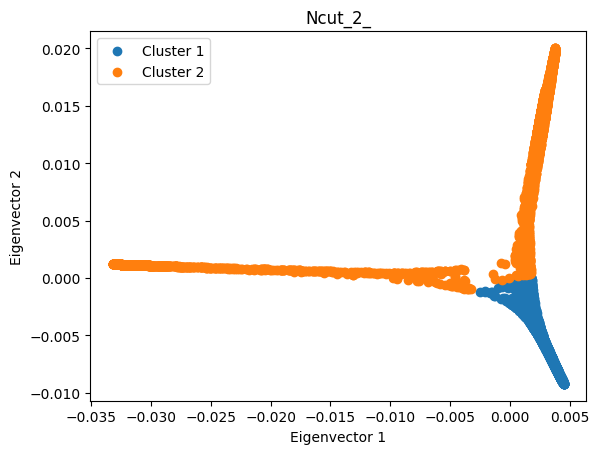


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 330 seconds

			Show Eigen values for spectral clustering Ratio Cut 



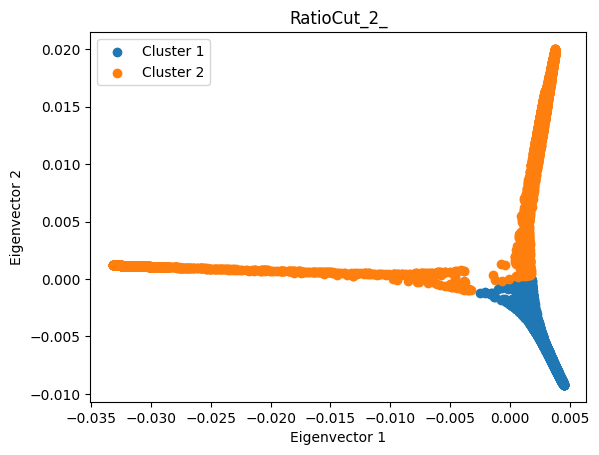


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 663 seconds 

		Image 2: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 5 seconds
			Normalized Cut Execution Time: 327 seconds

			Show Eigen values for spectral clustering Normalized Cut 



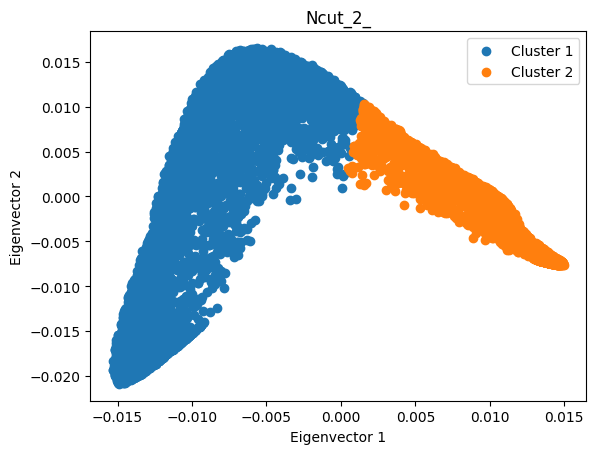


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 330 seconds

			Show Eigen values for spectral clustering Ratio Cut 



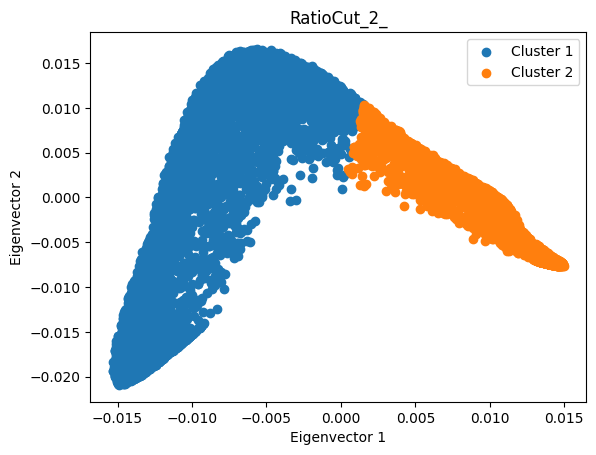


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 663 seconds 

	Clusters = 3
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 4 seconds
			Normalized Cut Execution Time: 324 seconds

			Show Eigen values for spectral clustering Normalized Cut 



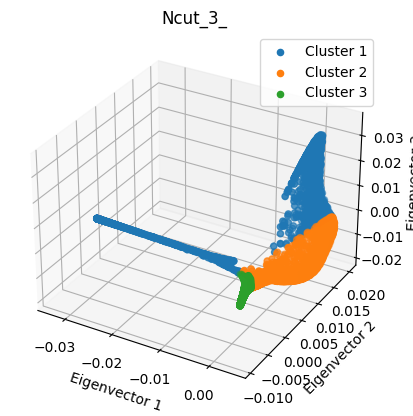


			Eigenspace Clusters Execution Time: 2 seconds 

			Ratio Cut Execution Time: 330 seconds

			Show Eigen values for spectral clustering Ratio Cut 



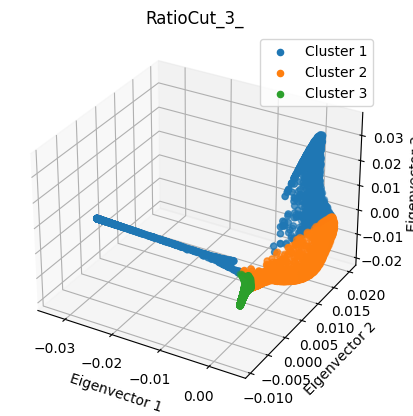


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 662 seconds 

		Image 2: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 5 seconds
			Normalized Cut Execution Time: 322 seconds

			Show Eigen values for spectral clustering Normalized Cut 



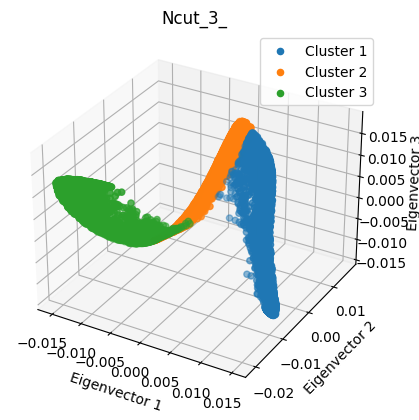


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 325 seconds

			Show Eigen values for spectral clustering Ratio Cut 



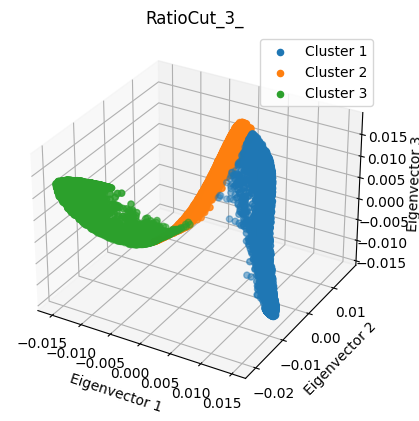


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 654 seconds 

	Clusters = 4
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 6 seconds
			Normalized Cut Execution Time: 322 seconds

			Show Eigen values for spectral clustering Normalized Cut 



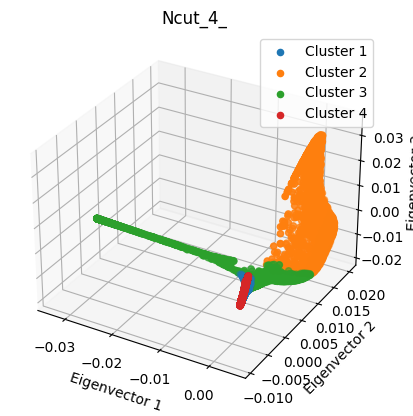


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 339 seconds

			Show Eigen values for spectral clustering Ratio Cut 



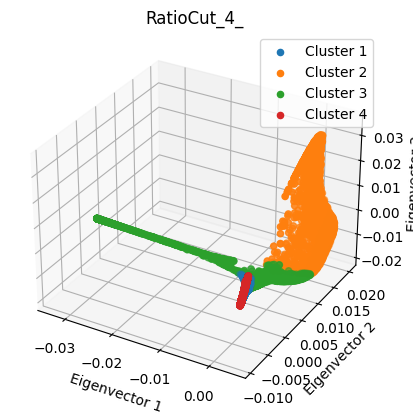


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 670 seconds 

		Image 2: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 4 seconds
			Normalized Cut Execution Time: 323 seconds

			Show Eigen values for spectral clustering Normalized Cut 



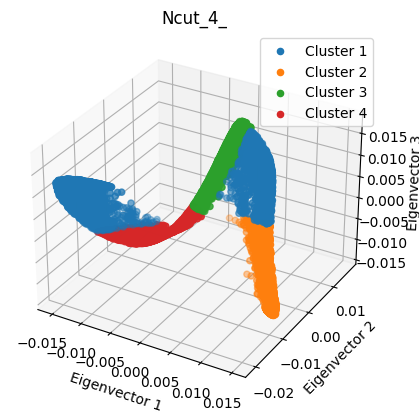


			Eigenspace Clusters Execution Time: 2 seconds 

			Ratio Cut Execution Time: 328 seconds

			Show Eigen values for spectral clustering Ratio Cut 



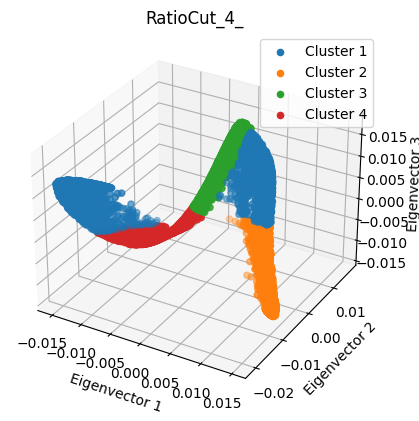


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 659 seconds 


Mode 1
	Clusters = 2
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 6 seconds
			Normalized Cut Execution Time: 322 seconds

			Show Eigen values for spectral clustering Normalized Cut 



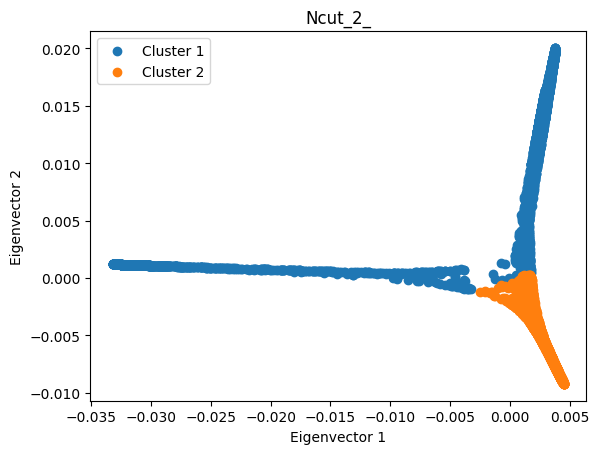


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 335 seconds

			Show Eigen values for spectral clustering Ratio Cut 



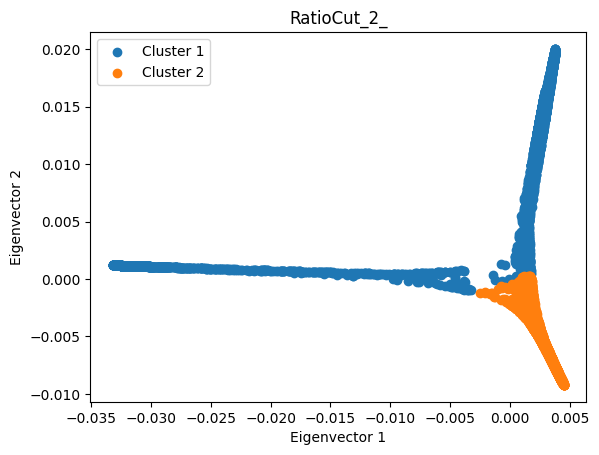


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 664 seconds 

		Image 2: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 4 seconds
			Normalized Cut Execution Time: 329 seconds

			Show Eigen values for spectral clustering Normalized Cut 



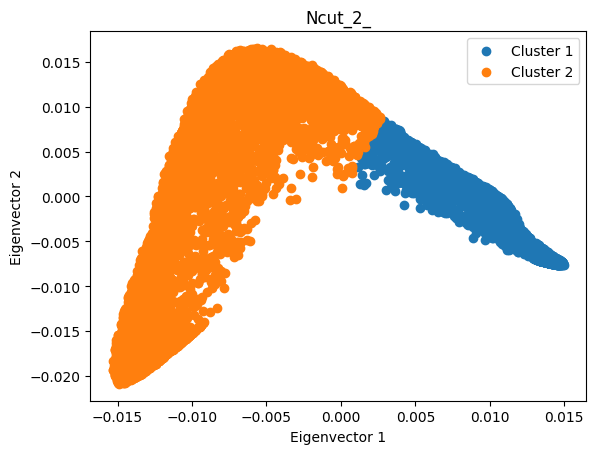


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 322 seconds

			Show Eigen values for spectral clustering Ratio Cut 



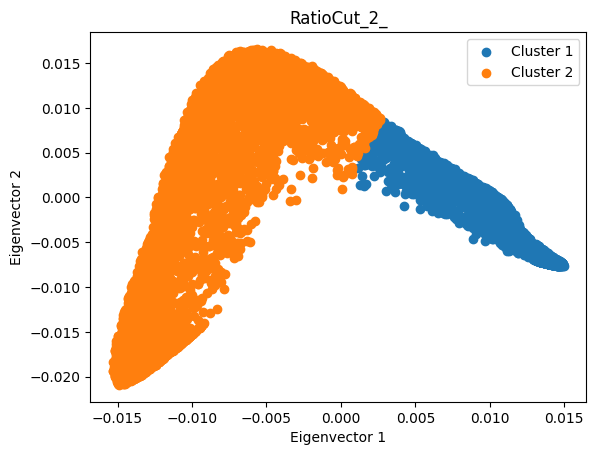


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 656 seconds 

	Clusters = 3
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 4 seconds
			Normalized Cut Execution Time: 330 seconds

			Show Eigen values for spectral clustering Normalized Cut 



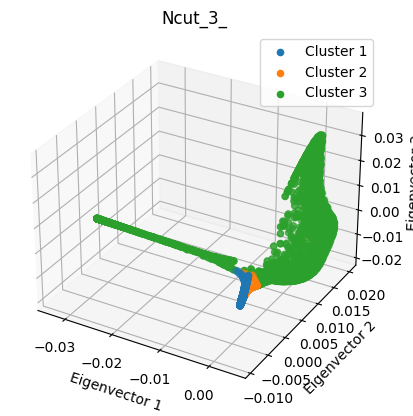


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 331 seconds

			Show Eigen values for spectral clustering Ratio Cut 



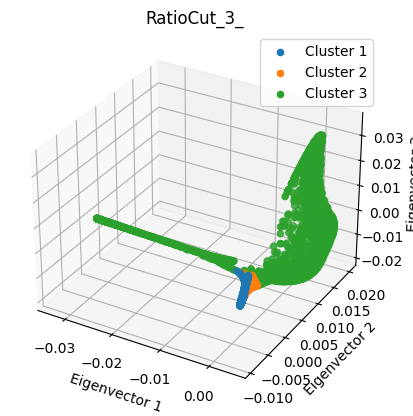


			Eigenspace Clusters Execution Time: 1 seconds 

			Total Execution Time: 668 seconds 

		Image 2: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 6 seconds
			Normalized Cut Execution Time: 327 seconds

			Show Eigen values for spectral clustering Normalized Cut 



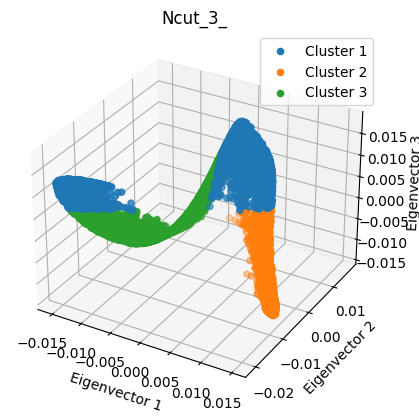


			Eigenspace Clusters Execution Time: 1 seconds 

			Ratio Cut Execution Time: 319 seconds

			Show Eigen values for spectral clustering Ratio Cut 



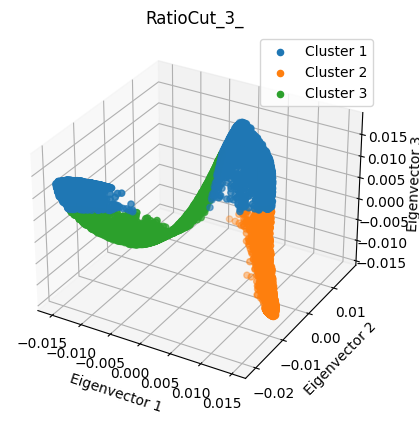


			Eigenspace Clusters Execution Time: 2 seconds 

			Total Execution Time: 655 seconds 

	Clusters = 4
		Image 1: 
			Read Image Execution Time: 0 seconds
			Compute Similarity Graph Matrix Execution Time: 4 seconds


In [ ]:
'''
We will be using some of the functions already defined above in Kernel K-Means
'''

# Normalized spectral clustering according to Ng, Jordan, and Weiss (2002)
def compute_laplacian(W, symmetric=True):
    ''' Degree Matrix D '''
    D = np.diag(np.sum(W, axis = 1))
    ''' Unnormalized Laplacian '''
    L = D - W
    if symmetric:
        ''' Symmetric Normalized Laplacian '''

        ''' Efficient computation of D^(-1/2) '''
        D_inv_sqrt = np.sqrt(1 / D.diagonal())
        ''' Element-wise multiplication by D^(-1/2) for rows and columns '''
        L_sym = D_inv_sqrt[:, np.newaxis] * L * D_inv_sqrt
        return L_sym
    return L

# Function for Eigenvalue Decomposition and get Eigenvector Matrix
def eigen_decomposition(Laplacian, num_clusters):
    ''' Compute the eigenvalues and eigenvectors '''
    eigenvalues, eigenvectors = np.linalg.eigh(Laplacian)
    ''' Select the eigenvectors corresponding to the smallest
        non-zero eigenvalues '''
    '''     while skipping the first eigenvalue because = 0 '''
    indices = np.argsort(eigenvalues)[1: num_clusters + 1]
    U = eigenvectors[:, indices]
    return U

# Function to Normalize the Rows of the Eigenvector Matrix
def normalize_rows(U):
    ''' Normalize each row to have unit Euclidean norm 1 '''
    U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)
    return U_normalized

# Function to assign each data point the nearest center
def clustering(array_, centers):
    ''' Calculate distances from each point to each center '''
    distances = cdist(array_, centers, 'sqeuclidean')
    ''' Assign each point to the nearest center '''
    clusters = np.argmin(distances, axis=1)
    return clusters

# Function for performing K-Means in Spectral Clustering
def k_means(matrix, num_clusters, iterations, output_dir, mode, image_number, title):
    if mode == 0:
        title = 'ratio'
    else:
        title = 'normalized'

    Total = len(matrix)

    ''' Get indices of centroids '''
    centroids = initial_centroids(kernel, num_clusters, Total, mode)
    ''' Associate centroids to corresponding centers'''
    centers = []
    for i in range(num_clusters):
        centers.append(matrix[centroids[i]])
    centers = np.array(centers)

    ''' Assign clusters '''
    clusters = clustering(matrix, centers)
    ''' Create and save image based on clusters '''
    write_image(Total, num_clusters, clusters, f'{mode}_{image_number}_{title}_{num_clusters}_', 0, output_dir)

    ''' Iterate over loop to update clusters by K-Means '''
    for i in range(1, iterations):

        ''' Initialize new_clusters as empty list '''
        new_centers = []
        for j in range(num_clusters):
            ''' Find "indices" that match with the cluster j '''
            mask = clusters == j
            ''' Update a new center as a mean of the data points in cluster j '''
            new_centers.append(np.sum(matrix[mask], axis=0) / len(matrix[mask]))
        ''' Transform the list into an array '''
        new_centers = np.array(new_centers)

        ''' Create and save image based on new_clusters '''
        new_clusters = clustering(matrix, new_centers)
        write_image(Total, num_clusters, clusters, f'{mode}_{image_number}_{title}_{num_clusters}_', i, output_dir)

        ''' Check for convergence '''
        if(np.linalg.norm((centers - new_centers), ord=2) < 1e-2):
            last_iteration = i
            break
        last_iteration = i
        centers = new_centers

    ''' Create GIF from the saved images and save it '''
    compose_gif(f'{mode}_{image_number}_{title}_{num_clusters}_', last_iteration, output_dir)

    return new_clusters


# Function to compute Spectral Clustering Normalized Cut
def spectral_clustering_normalized(matrix_kernel, W, K, iterations, mode, image_number, dir_normalized_cut):
    ''' Step 1: Compute Symmetric Normalized Laplacian Matrix '''
    L_sym = compute_laplacian(W, symmetric=True)

    ''' Step 2: Eigenvalue Decomposition '''
    ''' Eigenvector Matrix containing k smallest eigenvectors of L_sym '''
    U = eigen_decomposition(L_sym, K)

    ''' Save U for rapid code testing '''
    if image_number == 1:
        np.save(os.path.join(dir_normalized_cut, "_1_normalized_eigenvector.npy"), U)
        pass
    elif image_number == 2:
        np.save(os.path.join(dir_normalized_cut, "_2_normalized_eigenvector.npy"), U)
        pass
    else:
        perprint("\nYour input image index is neither 1 nor 2. \n ")

    ''' Load U for rapid code testing '''
    if image_number == 1:
        U = np.load(os.path.join(dir_normalized_cut, "_1_normalized_eigenvector.npy"))
    elif image_number == 2:
        U = np.load(os.path.join(dir_normalized_cut, "_2_normalized_eigenvector.npy"))
    else:
        perprint("\nYour input image index is neither 1 nor 2. \n ")

    ''' Step 3: Normalize Rows, this is matrix T in the algorithm '''
    U_norm = normalize_rows(U) # AKA matrix T

    ''' Step 4: Apply K-means '''
    cluster = k_means(U_norm, K, iterations, dir_normalized_cut, mode, image_number, "Ncut")

    ''' Return final cluster obtained from K-Means clustering and U '''
    return cluster, U


# Function to compute Spectral Clustering Ratio Cut
def spectral_clustering_ratio(matrix_kernel, W, K, iterations, mode, image_number, dir_ratio_cut):
    ''' Step 1: Compute unnormalized Laplacian Matrix '''
    L = compute_laplacian(W, symmetric=False)

    ''' Step 2: Eigenvalue Decomposition '''
    ''' Eigenvector Matrix containing k smallest eigenvectors of L '''
    U = eigen_decomposition(L, K)

    ''' Save U for rapid code testing '''
    if image_number == 1:
        np.save(os.path.join(dir_ratio_cut, "_1_ratio_eigenvector.npy"), U)
        pass
    elif image_number == 2:
        np.save(os.path.join(dir_ratio_cut, "_2_ratio_eigenvector.npy"), U)
        pass
    else:
        perprint("\nYour input image index is neither 1 nor 2. \n ")

    ''' Load U for rapid code testing '''
    if image_number == 1:
        U = np.load(os.path.join(dir_ratio_cut, "_1_ratio_eigenvector.npy"))
    elif image_number == 2:
        U = np.load(os.path.join(dir_ratio_cut, "_2_ratio_eigenvector.npy"))
    else:
        perprint("\nYour input image index is neither 1 nor 2. \n ")

    ''' Step 3: Apply K-means '''
    cluster = k_means(U, K, iterations, dir_ratio_cut, mode, image_number, "RatioCut")

    ''' Return final cluster obtained from K-Means clustering and U '''
    return cluster, U


# Function to plot eigenspace clusters
def plot_eigenspace_clusters(U, clusters, K, title, output_dir, image_number):
    ''' Select the first two or three eigenvectors for plotting '''
    if U.shape[1] >= 3:
        ''' for 3D plotting '''
        eig_vecs = U[:, :3]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        ''' for 2D plotting '''
        eig_vecs = U[:, :2]
        fig, ax = plt.subplots()

    ''' Generate a color map '''
    cmap = plt.colormaps['viridis']
    colors = [cmap(i / K) for i in range(K)]

    ''' Plot each cluster '''
    for i in range(K):
        cluster_points = eig_vecs[clusters == i]
        ax.scatter(*cluster_points.T, label=f'Cluster {i+1}')

    ''' Label axes and add title '''
    ax.set_xlabel('Eigenvector 1')
    ax.set_ylabel('Eigenvector 2')
    if eig_vecs.shape[1] == 3:
        ax.set_zlabel('Eigenvector 3')
    ax.set_title(title)

    ''' Add a legend '''
    ax.legend()

    ''' Save the plot '''
    image_path = os.path.join(output_dir, f"{mode}_{image_number}_{title}_eigenspace_cluster.png")
    plt.savefig(image_path)
    plt.show()

#_______________________________________________________
#_______________________________________________________
if __name__=='__main__':
    # Ensure output directories exist
    os.makedirs(dir_spectral_clustering_normalized_cut, exist_ok=True)
    os.makedirs(dir_spectral_clustering_ratio_cut, exist_ok=True)

    ''' Parameters '''
    k_values = [2, 3, 4] # Number of clusters
    s = 0.0001  # gamma_s of kernel function
    c = 0.001   # gamma_c of kernel function
    max_iter = 30 # Max number of images for the GIF images
    modes = [0, 1] # Integers, if 0 then random initialization, otherwise K-means++ initialization

    #_________________________________________________________
    perprint("2023 ML HMW06 \n\
    Spectral Clustering with Normalized Cut\n\
    Part 1: Clustering into 2 clusters & Visualization.\n\
    Part 2: Try more clusters (e.g. 3 or 4 ...) & Visualization.\n\
    Part 3: Try different initializations (e.g. k-means++) & Visualization.")


    ''' Iterate over different initialization methods '''
    for mode in modes:
        perprint(f"\nMode {mode}")
        ''' Iterate over different number of clusters '''
        for k in k_values:
            perprint(f"\tClusters = {k}")
            ''' Process each image and run clustering algorithms '''
            for index, image_path in enumerate([path_image_1, path_image_2]):
                start_time_image = time.time() # Image processing execution starts

                perprint(f"\t\tImage {index+1}: ")
                ''' Read image '''
                start_time_read_image = time.time() # Image reading execution starts
                image = read_image(image_path)

                end_time_read_image = time.time() # Image reading execution ends
                elapsed_time_read_image = int(round(end_time_read_image - start_time_read_image))
                perprint(f"\t\t\tRead Image Execution Time: {elapsed_time_read_image} seconds")

                ''' Compute kernel matrix then the similarity matrix/Graph W '''
                start_time_compute_graph = time.time() # Compute kernel matrix execution starts
                kernel = compute_kernel(image, s, c)

                ''' Set diagonal elements to 0 to get W '''
                similarity_graph = np.copy(kernel)
                np.fill_diagonal(similarity_graph, 0)

                end_time_compute_graph = time.time() # Compute kernel matrix execution ends
                elapsed_time_compute_graph = int(round(end_time_compute_graph - start_time_compute_graph))
                perprint(f"\t\t\tCompute Similarity Graph Matrix Execution Time: {elapsed_time_compute_graph} seconds")

                ########
                ''' Spectral Clustering Normalized Cut '''
                start_time_norm_cut = time.time() # Kernel K-Means execution starts
                cluster_norm, U_norm = spectral_clustering_normalized(kernel, similarity_graph, k, max_iter, mode, index+1, dir_spectral_clustering_normalized_cut)
                end_time_norm_cut = time.time() # Kernel K-Means execution stops
                elapsed_time_norm_cut = int(round(end_time_norm_cut - start_time_norm_cut))
                perprint(f"\t\t\tNormalized Cut Execution Time: {elapsed_time_norm_cut} seconds")

                perprint("\n\t\t\tShow Eigen values for spectral clustering Normalized Cut \n")
                start_time_eigen_cluster = time.time() # plot_eigenspace_clusters() execution starts
                plot_eigenspace_clusters(U_norm, cluster_norm, k, f'Ncut_{k}_', dir_spectral_clustering_normalized_cut, index+1)
                end_time_eigen_cluster = time.time() # plot_eigenspace_clusters() execution ends
                elapsed_time_eigen_cluster = int(round(end_time_eigen_cluster - start_time_eigen_cluster))
                perprint(f"\n\t\t\tEigenspace Clusters Execution Time: {elapsed_time_eigen_cluster} seconds \n")
                ########

                ########
                ''' Spectral Clustering Ratio Cut '''
                start_time_ratio_cut = time.time() # Kernel K-Means execution starts
                cluster_ratio, U_ratio = spectral_clustering_ratio(kernel, similarity_graph, k, max_iter, mode, index+1, dir_spectral_clustering_ratio_cut)
                end_time_ratio_cut = time.time() # Kernel K-Means execution stops
                elapsed_time_ratio_cut = int(round(end_time_ratio_cut - start_time_ratio_cut))
                perprint(f"\t\t\tRatio Cut Execution Time: {elapsed_time_ratio_cut} seconds")

                perprint("\n\t\t\tShow Eigen values for spectral clustering Ratio Cut \n")
                start_time_eigen_cluster_ratio = time.time() # plot_eigenspace_clusters() execution starts
                plot_eigenspace_clusters(U_norm, cluster_norm, k, f'RatioCut_{k}_', dir_spectral_clustering_ratio_cut, index+1)
                end_time_eigen_cluster_ratio = time.time() # plot_eigenspace_clusters() execution ends
                elapsed_time_eigen_cluster_ratio = int(round(end_time_eigen_cluster_ratio - start_time_eigen_cluster_ratio))
                perprint(f"\n\t\t\tEigenspace Clusters Execution Time: {elapsed_time_eigen_cluster_ratio} seconds \n")
                ########

                ''' Get Total Execution Time for Image'''
                end_time_image = time.time() # Image processing execution ends
                elapsed_time_image = int(round(end_time_image - start_time_image))
                perprint(f"\t\t\tTotal Execution Time: {elapsed_time_image} seconds \n")

    #_________________________________________________________


# **End of coding**

In [ ]:
perprint("\n\nEnd")
# Close the output file at the end of your code
output_file.close()



End
